<a href="https://colab.research.google.com/github/alejandromanas/GoogleColab_public/blob/master/Bookings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Booking cancellation prediction**

One of the most commom problems in tourism and travel industry is booking cancellations. Cancellation rate can range from 20% to 60% depending on the hotel type and location. 

Creating a classification model capable of predicting the probability of cancellation reduces losses and ensures better decision-making in the following areas:

* Booking management- get a better prediction of net demand (bookings - cancellations)

* Revenue Management- improve the data from which the pricing policy is set

* Resource management- Optimize the planning of purchases, services of external suppliers and staff organization. 

* Overbooking policies- Reduce the additional costs of acomodate guests in other hotels and the loss of confidence and bad publicity (bad reviews) that it can cause.

The project includes 3 models based on different techniques (logistic regression, XGBoost and lightGBM). All of them are classification models (the goal is to classify bookings into two groups, cancelled and not cancelled) and supervised (the response variable, the booking status, is known for each reservation and is used in the model training)

### Origin of information

The data was obtained from an article entitled "Hotel booking demand datasets" by Nuno Antonio, Anade Almeid and Luis Nunes .

URL: https://www.sciencedirect.com/science/article/pii/S2352340918315191)

The article includes a dataset with more than 120,000 reservations from two hotels of one of the major portuguese hotels brand. Both hotels have more than 200 rooms and a four stars rating. One is a city hotel located in Lisbon and the other is a resort hotel in the Algarve. The reservations have a date of arrival between 1 July 2015 and 31 August 2017. 

Each reservation includes about 35 variables or columns. Some of them are::
* booking status (cancelled or not cancelled)
* lead time
* number of nights (weekdays and weekends)
* average price per night
* distribution channel
* market segment
* room type
* number of guests (babes, childs or adults)

# **Models**

### Libraries & Functions

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

#Metrics

def predict_metrics(X,y,model):
  y_pred = pd.Series(model.predict(X))
  y_prob= model.predict_proba(X) 
    
  # Accuracy  
  print('Accuracy =',str(metrics.accuracy_score(y,y_pred)))
        
  # AUC
  fpr, tpr, threshold = metrics.roc_curve(y, y_prob[:,1])
  roc_auc = metrics.auc(fpr, tpr)
  print('AUC = %0.2f' % roc_auc)
        
  # Logloss
  Logloss = metrics.log_loss(y, y_prob[:,1])
  print('LogLoss = %0.2f' % Logloss)
        
  return y_pred,y_prob

# Time execution mesure
def tic():
  global _start_time 
  _start_time = time.time()

def tac():
  t_sec = round(time.time() - _start_time)
  (t_min, t_sec) = divmod(t_sec,60)
  (t_hour,t_min) = divmod(t_min,60) 
  time_elapsed=print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

### XG Boosting with stratified CV and GridSearch
def XGBC_Boss(X,Y,params):
    
  # time 
  _start_time = time.time()
    
  tic()
  
  # Splitting train and test
  
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)   
  y_train= y_train.to_numpy().ravel()   #convert to (n,) array
  y_test = y_test.to_numpy().ravel()    
    
  # Model
    
  xgbmodel=XGBClassifier()
     
  print('Fitting...')
    
  scoring = ['roc_auc']
  refit='roc_auc'

  kfold = model_selection.StratifiedShuffleSplit(n_splits=3, random_state=15)
  grid_solver = GridSearchCV(estimator = xgbmodel, # model to train
                     param_grid = params, # param_grid
                     #scoring = ['accuracy'],
                     scoring = scoring,
                     cv = kfold,
                     n_jobs=3, 
                     #refit = 'accuracy',
                     refit = refit,
                     verbose = 2)
    
  model_result_xgboost = grid_solver.fit(x_train,y_train)
    
  print('Best parameters: ',model_result_xgboost.best_estimator_)

  # return predictions
  Y_pred = pd.Series(model_result_xgboost.predict(x_train))
  Y_prob= model_result_xgboost.predict_proba(x_train)
    
  # Metrics and parameters

  print('***** RESULTS ***** \n***** TRAIN *****')
  predict_metrics(x_train,y_train,model_result_xgboost)
        
  print('***** TEST *****')
  predict_metrics(x_test,y_test,model_result_xgboost)
    
  print('***** ALL DATA *****')
  Y_pd = pd.DataFrame(Y_array)
  y_pred,y_prob=predict_metrics(X,Y,model_result_xgboost)

  tac() # time elapsed
      
  return Y_pred,Y_prob,model_result_xgboost

###LightGBM with stratified CV and GridSearch

def light_LGBM(X,y,param_grid):
    
  _start_time = time.time()
  tic()
     
  indexes_of_categories=[]
    
  lbl = preprocessing.LabelEncoder()
    
  for i in range(X.shape[1]):
      if X.dtypes[i]=='object':
          indexes_of_categories.append(i)
          lbl.fit(X.iloc[:,i])
          X.iloc[:,i]=lbl.transform(X.iloc[:,i])
        
  # Splitting
           
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)    
  y_train= y_train.to_numpy().ravel()   #convert to (n,) array
  y_test = y_test.to_numpy().ravel()         
          
  Kfold = model_selection.StratifiedShuffleSplit(n_splits=3, random_state=15)          
  gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train, y=y_train)
     
  lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary') 

  print('Fitting...')
    
  scoring = ['roc_auc']
  refit='roc_auc'
     
  gsearch = GridSearchCV(estimator=lgb_estimator, 
                         param_grid=param_grid, 
                         cv=gkf,scoring=scoring,
                         refit=refit,
                         verbose = 2)
    
  lgb_model = gsearch.fit(X=X_train, y=y_train)
    
  print('Results ********** ')
      
  print('Best parameters:',str(lgb_model.best_params_))
   
  print('********** TRAIN ********** ')
  predict_metrics(X_train,y_train,lgb_model)
        
  print('********** TEST ********** ')
  predict_metrics(X_test,y_test,lgb_model)
    
  print('********** ALL DATA ********** ')
  y_pred,y_prob=predict_metrics(X,y,lgb_model)
     
  # Plot importance PENDING
  # fig, ax = plt.subplots(figsize=(20, 15))
    
  # lgb.plot_importance(lgb_estimator,ax=ax)
  # lgb.plot_importance(gsearch.Booster,ax=ax)
  # lgb.plot_importance(lgb_model.Booster_Booster,ax=ax)
  # lgb.plot_importance(lgb_model,ax=ax)
    
  # plot_tree(lgb_model._Booster)
    
    
  # lgb_model.plot_importance()
  # # fig = plot_imp.figure
  # # fig.set_size_inches(5, 10)
  # plt.savefig('lightLGBM.png')
         
  # time
  tac()
    
  return y_pred,y_prob,


### Loading Files from Github

In [0]:
# data was preprocessed and imported from a personal Github repo
X = pd.read_csv("https://raw.githubusercontent.com/alejandromanas/GoogleColab_public/master/bookings/files/X.csv", delimiter = ',')
Y = pd.read_csv("https://raw.githubusercontent.com/alejandromanas/GoogleColab_public/master/bookings/files/Y.csv", delimiter = ',')

### Logistic Regresion

In [42]:
from sklearn.linear_model import LogisticRegression

# Lead Time
# tabla de contingencia
pd.crosstab(index=Y['IsCancelled'], columns=X['LeadTime'], margins=True)


x_train, x_test, y_train, y_test = train_test_split(X[['LeadTime']], Y, test_size=0.10, random_state=42)

clf = LogisticRegression(random_state=0, solver='lbfgs')
clf=clf.fit(x_train,y_train)
clf.coef_
clf.intercept_

predict_metrics(x_train,y_train,clf)


Accuracy = 0.6614642953532308
AUC = 0.69
LogLoss = 0.62


(0         0
 1         0
 2         0
 3         0
 4         0
          ..
 107446    0
 107447    1
 107448    0
 107449    0
 107450    0
 Length: 107451, dtype: int64, array([[0.76277645, 0.23722355],
        [0.7595872 , 0.2404128 ],
        [0.52441936, 0.47558064],
        ...,
        [0.66169827, 0.33830173],
        [0.64581506, 0.35418494],
        [0.70590043, 0.29409957]]))

### XGboost

 “Extreme Gradient Boosting” is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set. 

In [0]:
params={'base_score': [0.8], 
         'booster': ['gbtree'],
         'colsample_bylevel': [1], 
         'colsample_bytree': [0.8], 
         'gamma': [0.01],
         'learning_rate': [0.01], 
         'max_depth': [6],
         'min_child_weight': [1],
         'missing': [None],
         'n_estimators': [400],
         'n_jobs': [-1], 
         'objective': ['binary:logistic'],
         'random_state': [15], 
         'reg_alpha': [0.01], 
         'reg_lambda': [0.01],
         'scale_pos_weight': [1],
         'subsample': [0.9]}  

Y_pred,Y_prob,model_result_xgboost=XGBC_Boss(X,Y,params)

Fitting...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  3.3min finished


***** RESULTS ***** 
***** TRAIN *****
Accuracy = 0.8290290457976194
AUC = 0.90
LogLoss = 0.37
***** TEST *****
Accuracy = 0.8298852500209398
AUC = 0.90
LogLoss = 0.37
***** ALL DATA *****
Accuracy = 0.8291146662199514
AUC = 0.90
LogLoss = 0.37
Best parameters:  XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=15,
              reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)
Time passed: 0hour:5min:1sec


### Results

>Split | Accuracy |  AUC |  Logloss
>--- | --- | --- | ---
>TRAIN | 0.82902 | 0,90 | 0,37
>TEST | 0.82988 | 0,90 | 0,37
>ALL | 0.82911 | 0,90 | 0,37

### Features used in the model

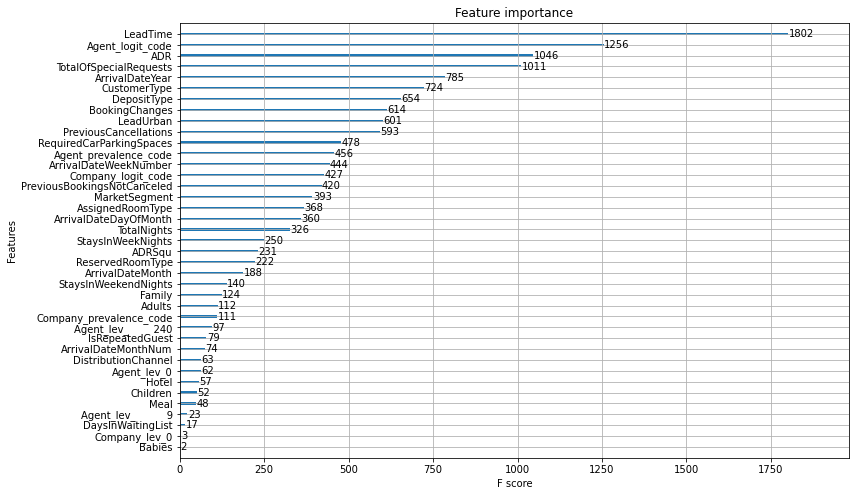

In [0]:
#xgbm=model_result_xgboost.best_estimator_

# Plot importance
#fig, ax = plt.subplots(figsize=(20, 15))
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model_result_xgboost.best_estimator_,ax=ax)

### lightGBM

In [0]:

param_grid = {
'num_leaves': [31],
'learning_rate':[0.1],
'min_data_in_leaf': [30],
'lambda_l1': [0],
'lambda_l2': [0],
'max_depth': [3],
}  

y_pred,y_prob = light_LGBM(X,Y,param_grid)

Fitting...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31, total=   1.5s
[CV] lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31, total=   1.5s
[CV] lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31 
[CV]  lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31, total=   1.6s
[CV] lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31 
[CV]  lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31, total=   1.5s
[CV] lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31 
[CV]  lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31, total=   1.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.6s finished


Results ********** 
Best parameters: {'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 30, 'num_leaves': 31}
********** TRAIN ********** 
Accuracy = 0.8264418199923687
AUC = 0.90
LogLoss = 0.37
********** TEST ********** 
Accuracy = 0.829047658932909
AUC = 0.90
LogLoss = 0.37
********** ALL DATA ********** 
Accuracy = 0.8267024038864227
AUC = 0.90
LogLoss = 0.37
Time passed: 0hour:0min:11sec


In [0]:
from sklearn.model_selection import KFold
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train, y=y_train)

NameError: ignored